In [1]:
%load_ext autoreload
%autoreload 2


## DriftMLP is the package implementing this methodology
import DriftMLP
## h3 to convert locations to their h3 indices.
## Where possible we use DriftMLP.helpers.return_h3_inds()
import h3.api.basic_int as h3

## core python packages
import os
import numpy as np #
import pandas as pd
import pickle


## Matplotlib for plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
## Cartopy for map projections
import cartopy.crs as ccrs
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
def get_non_zeros(arr):
    mask = arr!=0
    return arr[mask].flatten()
def nested_list_of_paths_to_tt(nested_list):
    return [[path.travel_time for path in list_of_paths] for list_of_paths in nested_list]


## geopandas for aid storing Polygons and plotting
import geopandas as gpd
from shapely.geometry import Polygon


import string
alphabet = string.ascii_lowercase

def get_non_zeros(arr):
    mask = arr!=0
    return arr[mask].flatten()


driftfile = os.environ['DRIFTFILE'] 
### Generated by MakeDefNetworks
networks = pickle.load(open('default_networks.p', 'rb'))

### Only use drogued drifters
network = networks[True]
postfix = 'drg'
del networks
### Our example locations are in locations.txt
stations = np.loadtxt("locations.txt", delimiter=',')
stations = pd.DataFrame(stations, index=range(1, 8))
stations.columns = ['Longitude', 'Latitude']
stations['h3'] = DriftMLP.helpers.return_h3_inds([i[['Longitude', 'Latitude']].to_list() for _,i in stations.iterrows()])

# Sensitivity to Hyper Parameter

- Lagrangian cut off point

# Lagranigan cut off point

To assess how accurate the Lagrangian cut off time is we will investigate how the travel times changes as we use a range of different values.

The measurement will be the average difference between the 5 day travel time matrix and the x day travel time matrix.
we will:

1. Create the network for each value of $\mathcal{T}_L$.

2. Obtain a travel time matrix for each trial value.

3. Plot an example, comparing the off-diagonal elements of the travel time matrix at $\mathcal{T}_L=5$ and a $\mathcal{T}_L$ to see if there's a linear trend.

4. Look at the spearman correlation between the travel time matrix at $\mathcal{T}_L=5$ and a $\mathcal{T}_L$.

In [2]:
stories = network['stories']
observations_per_day = network['observations_per_day']
trial_cut_offs = list(np.arange(0.5,14.0,0.5))
def new_network(stories, day_cut_off, observations_per_day):
    return DriftMLP.form_network.make_transition(stories, day_cut_off, observations_per_day)
print(trial_cut_offs)

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5]


In [3]:
networks = [new_network(stories, trial_cut_off, observations_per_day) for trial_cut_off in trial_cut_offs]

In [4]:
locs = stations['h3'].tolist()
l = trial_cut_offs.index(5)
five_network = networks.pop(l)
trial_cut_offs.pop(l)
all_paths = [DriftMLP.shortest_path.AllPairwisePaths(network, locs) for network in networks]
paths_used = DriftMLP.shortest_path.AllPairwisePaths(five_network, locs)

In [5]:
def nested_list_of_paths_to_tt(nested_list):
    return [[path.travel_time for path in list_of_paths] for list_of_paths in nested_list]
all_tts = np.array([nested_list_of_paths_to_tt(nested_list) for nested_list in all_paths])
our_tts = np.array(nested_list_of_paths_to_tt(paths_used))
N = our_tts.shape[0]
num_nonzero = (N*(N-1)/2)

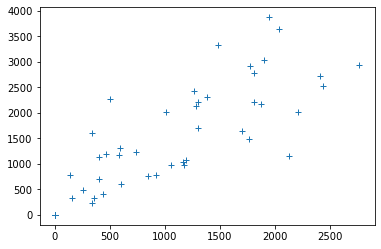

In [6]:
plt.plot(all_tts[2,:,:].flatten(), our_tts.flatten(), '+')

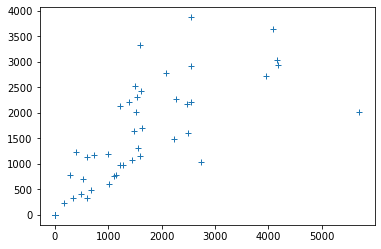

In [7]:
plt.plot(all_tts[-1,:,:].flatten(), our_tts.flatten(), '+')

In [8]:
from scipy.stats import spearmanr, pearsonr
from matplotlib import rc
rc('text', usetex=True)

non_zero_tts = [get_non_zeros(all_tts[i, :,:]) for i in range(all_tts.shape[0])]
mark = get_non_zeros(our_tts)
fig = plt.figure()
corrs = [spearmanr(mark, non_zero_tt)[0] for non_zero_tt in non_zero_tts]
plt.plot(trial_cut_offs, corrs ,'bo-',label='spearman')
#corrs = [pearsonr(mark, non_zero_tt)[0] for non_zero_tt in non_zero_tts]
#plt.plot(trial_cut_offs, corrs ,'ro-',label='pearson', )
ax = fig.gca()
ax.grid()
ax.set_xlabel('$\mathcal{T}_L$')
ax.set_ylabel('Spearman Correlation ')
ax.set_title('Correlation between travel time matrices using different $\mathcal{T}_L$ values \n to travel time at $\mathcal{T}_L=5$')

fig.savefig('Images/cut_off_time.png')
fig.savefig('Images/cut_off_time.pdf')

# Rotations

For comparsion purposes, we get the correlation between the travel times computed at $\mathcal{T}_l=5$ with no rotation and $\mathcal{T}_l=5$ for each of the 100 rotations.

In [9]:
## Number of rotations
nets = pickle.load(open('rotations_100.p', 'rb'))
origins = [stations.iloc[i].loc[['Longitude', 'Latitude']].to_list() for i in range(stations.shape[0])]
print(origins)
plot_n=len(nets)
def nested_list_of_paths_to_tt(nested_list):
    return [[path.travel_time for path in list_of_paths] for list_of_paths in nested_list]
from shapely.geometry import Point
def get_all_paths(network):
    indices = DriftMLP.helpers.return_h3_inds(origins, rot=network['rotation'])
    paths = DriftMLP.shortest_path.AllPairwisePaths(network, indices)
    return paths
#%timeit path_and_df(nets[5],network['gpd'])
res = []
for i in range(plot_n):
    res.append(get_all_paths(nets[i]))
    
tt_mats = list(map(nested_list_of_paths_to_tt,res))
del(nets)

[[9.0, -25.5], [-25.0, -5.0], [-45.0, -40.0], [-69.0, 39.0], [-42.5, 41.5], [-42.0, 27.5], [-93.2, 24.8]]


In [10]:
rot_matrices = np.array(tt_mats)
non_zero_tts = [get_non_zeros(rot_matrices[i, :,:]) for i in range(rot_matrices.shape[0])]
corrs = [spearmanr(mark, non_zero_tt)[0] for non_zero_tt in non_zero_tts]

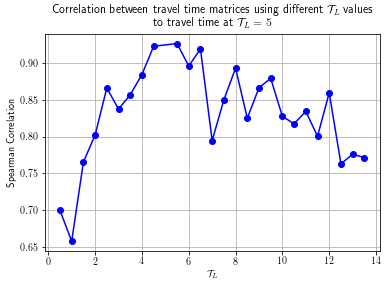

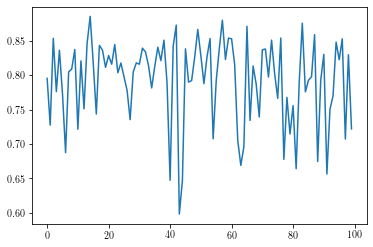

In [11]:
plt.figure()
plt.plot(list(range(100)), corrs)

The mean is below, which is usally lower than the correlation across the $\mathcal{T}_L$, implying that the value of $\mathcal{T}_L$ is not overly sensitive.

In [12]:
np.mean(corrs)

0.7928158171947168